In [1]:
# import all packages that might be useful
import sys # to manipulate different part of python runtime environment
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=15,8
import seaborn as sns
from scipy.stats import randint
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
df = pd.read_csv(r'ncdc_covid_data.csv')

In [3]:
df.head()

,Date,Confirmed cases,New cases,Total deaths,New deaths,Total recovery,Active cases
0,09/08/2021,197046,559,2578,5,185379,9089
1,09/07/2021,196487,597,2573,17,185159,8755
2,09/06/2021,195890,379,2556,4,184882,8452
3,09/05/2021,195511,459,2552,30,184530,8429
4,09/04/2021,195052,964,2522,27,182463,10067


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             19 non-null     object
 1   Confirmed cases  19 non-null     int64 
 2   New cases        19 non-null     int64 
 3   Total deaths     19 non-null     int64 
 4   New deaths       19 non-null     int64 
 5   Total recovery   19 non-null     int64 
 6   Active cases     19 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 1.0+ KB


In [5]:
#Make the date column be of date data type. It is of object data type by default
df['Date'] = pd.to_datetime(df['Date'])


In [6]:
df=df.set_index('Date')

In [7]:
df.head()

,Confirmed cases,New cases,Total deaths,New deaths,Total recovery,Active cases
Date,,,,,,
2021-09-08,197046,559,2578,5,185379,9089
2021-09-07,196487,597,2573,17,185159,8755
2021-09-06,195890,379,2556,4,184882,8452
2021-09-05,195511,459,2552,30,184530,8429
2021-09-04,195052,964,2522,27,182463,10067


In [8]:
df.tail()

,Confirmed cases,New cases,Total deaths,New deaths,Total recovery,Active cases
Date,,,,,,
2021-08-25,188880,637,2288,7,169382,17210
2021-08-24,188243,655,2281,5,169035,16927
2021-08-23,187588,565,2276,8,168818,16494
2021-08-22,187023,388,2268,8,168455,16300
2021-08-21,186635,1064,2260,13,168320,16055


In [9]:
df.shape

(19, 6)

In [10]:
#Check if there are missing values. The output shows ther are no missing values
df.isnull().sum()

Confirmed cases    0
New cases          0
Total deaths       0
New deaths         0
Total recovery     0
Active cases       0
dtype: int64

In [11]:
df['Total recovery_logged']= np.log(df['Total recovery'])

In [12]:
df.head()

,Confirmed cases,New cases,Total deaths,New deaths,Total recovery,Active cases,Total recovery_logged
Date,,,,,,,
2021-09-08,197046,559,2578,5,185379,9089,12.130158
2021-09-07,196487,597,2573,17,185159,8755,12.128970
2021-09-06,195890,379,2556,4,184882,8452,12.127473
2021-09-05,195511,459,2552,30,184530,8429,12.125567
2021-09-04,195052,964,2522,27,182463,10067,12.114303


## ARIMA

### Our focus here is to forecast for New cases, New deaths and Total recovery. So, we will focus on these three variables.

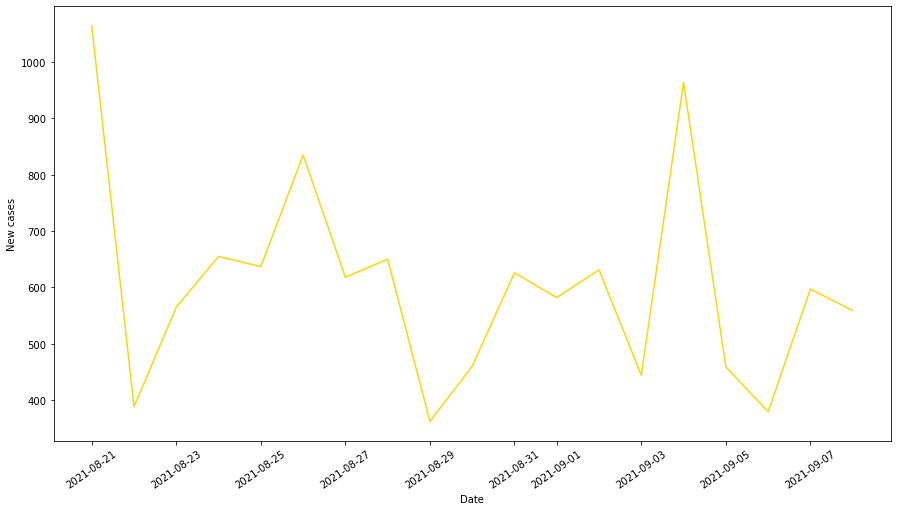

In [13]:
#Plot the variables to observes the trends present in them
sns.lineplot(df.index,df['New cases'],color='gold')
plt.xlabel('Date')
plt.xticks(rotation=35);

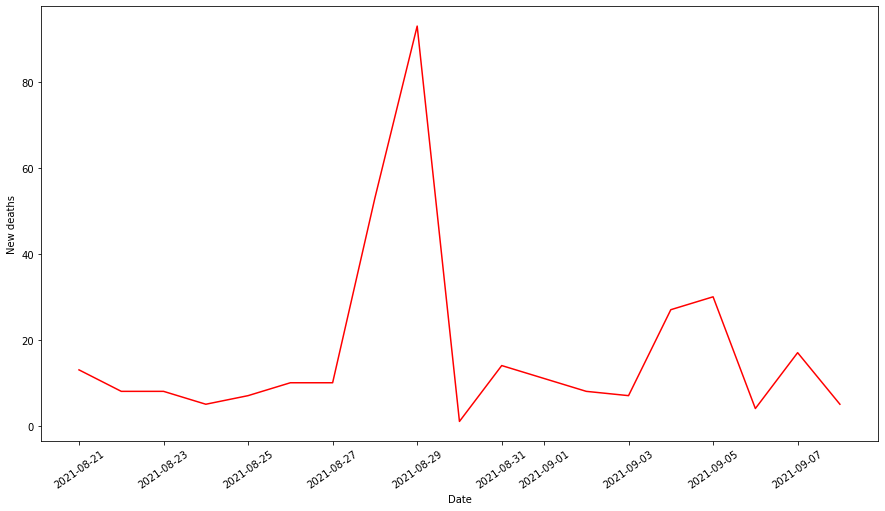

In [14]:
sns.lineplot(df.index,df['New deaths'],color='r')
plt.xlabel('Date')
plt.xticks(rotation=35);

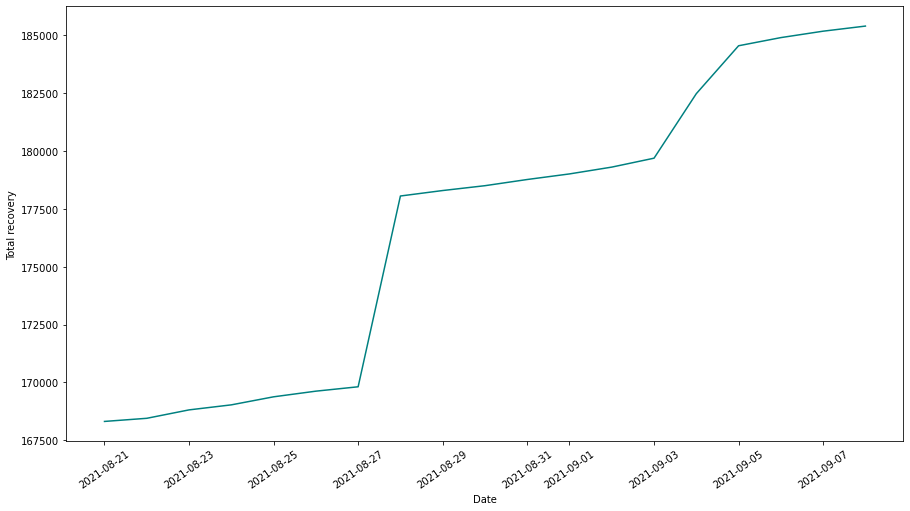

In [15]:
sns.lineplot(df.index,df['Total recovery'],color='teal')
plt.xlabel('Date')
plt.xticks(rotation=35);

## In ARIMA, the first thing is to identify if the data is stationary or non-stationary

In [ ]:
#TESTING THE STATIONARITY OF OUR SERIES. We do this for all the 3 variables of interest.
# H0: Series has a unit root/It is not stationary
# H1: Series has no unit root/It is not stationary

In [83]:
result = adfuller(df['New cases'])
print(f'Test Statistic:{result[0]}')
print(f'p-value:{result[1]}')
print(f'Critical_values:{result[4]}')
if result[1]>0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

Test Statistic:-4.491453714813385
p-value:0.0002037513822078425
Critical_values:{'1%': -3.859073285322359, '5%': -3.0420456927297668, '10%': -2.6609064197530863}
Series is stationary


In [84]:
result = adfuller(df['New deaths'])
print(f'Test Statistic:{result[0]}')
print(f'p-value:{result[1]}')
print(f'Critical_values:{result[4]}')
if result[1]>0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

Test Statistic:-3.269373386877679
p-value:0.01630423662331983
Critical_values:{'1%': -3.859073285322359, '5%': -3.0420456927297668, '10%': -2.6609064197530863}
Series is stationary


In [135]:
result = adfuller((df['Total recovery_logged']))
print(f'Test Statistic:{result[0]}')
print(f'p-value:{result[1]}')
print(f'Critical_values:{result[4]}')
if result[1]>0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

Test Statistic:24.743079276993196
p-value:1.0
Critical_values:{'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
Series is not stationary


### New cases and New deaths are stationary. But Total recovery is not stationary, so we difference it to make it stationary

In [137]:
df.head()

,Date,Confirmed cases,New cases,Total deaths,New deaths,Total recovery,Active cases,Total recovery_logged
0,2021-09-08,197046,559,2578,5,185379,9089,12.130158
1,2021-09-07,196487,597,2573,17,185159,8755,12.128970
2,2021-09-06,195890,379,2556,4,184882,8452,12.127473
3,2021-09-05,195511,459,2552,30,184530,8429,12.125567
4,2021-09-04,195052,964,2522,27,182463,10067,12.114303


In [92]:
df['Total recovery_differenced']= df['Total recovery_differenced'].fillna(0)

In [93]:
result = adfuller(df['Total recovery_differenced'])
print(f'Test Statistic:{result[0]}')
print(f'p-value:{result[1]}')
print(f'Critical_values:{result[4]}')
if result[1]>0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

Test Statistic:0.5104691530507893
p-value:0.9851878481155817
Critical_values:{'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
Series is not stationary


In [94]:
df['Total recovery_differenced_differenced']= df['Total recovery_differenced'].diff()

In [95]:
df.head()

,Date,Confirmed cases,New cases,Total deaths,New deaths,Total recovery,Active cases,Total recovery_differenced,Total recovery_differenced_differenced
0,2021-09-08,197046,559,2578,5,185379,9089,0.0,NaN
1,2021-09-07,196487,597,2573,17,185159,8755,-220.0,-220.0
2,2021-09-06,195890,379,2556,4,184882,8452,-277.0,-57.0
3,2021-09-05,195511,459,2552,30,184530,8429,-352.0,-75.0
4,2021-09-04,195052,964,2522,27,182463,10067,-2067.0,-1715.0


In [99]:
df['Total recovery_differenced_differenced']= df['Total recovery_differenced_differenced'].fillna(0)

In [100]:
result = adfuller(df['Total recovery_differenced_differenced'])
print(f'Test Statistic:{result[0]}')
print(f'p-value:{result[1]}')
print(f'Critical_values:{result[4]}')
if result[1]>0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

Test Statistic:-0.806482497020672
p-value:0.8172104627667285
Critical_values:{'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
Series is not stationary


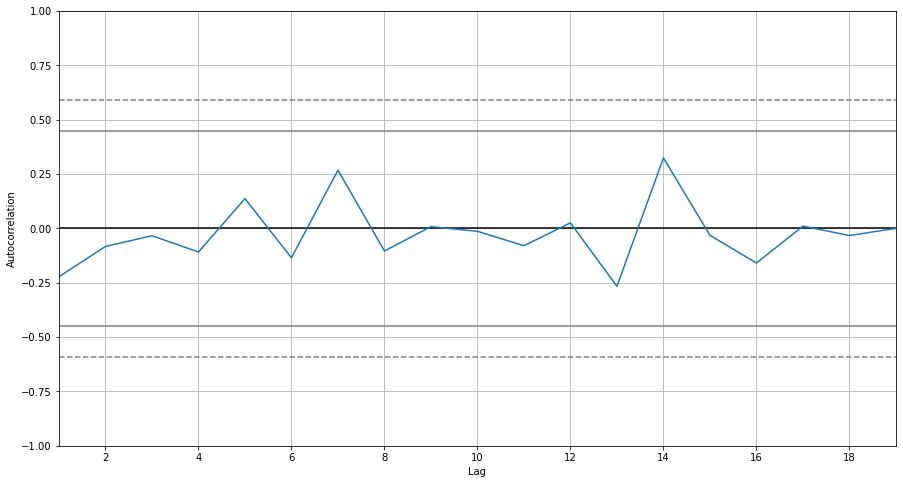

In [16]:
#ACheck for autocorrelation with the utocorrelation plot
autocorrelation_plot(df['New cases'])
plt.show();

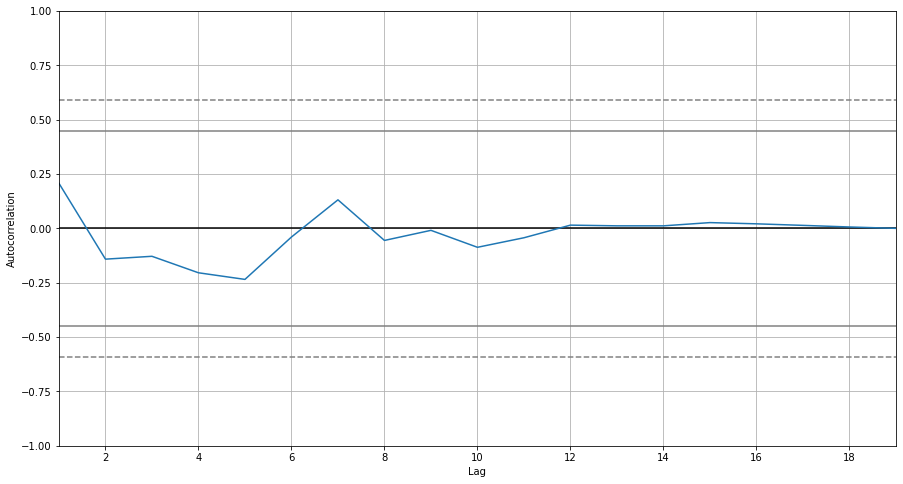

In [17]:
#Autocorrelation plot
autocorrelation_plot(df['New deaths'])
plt.show();

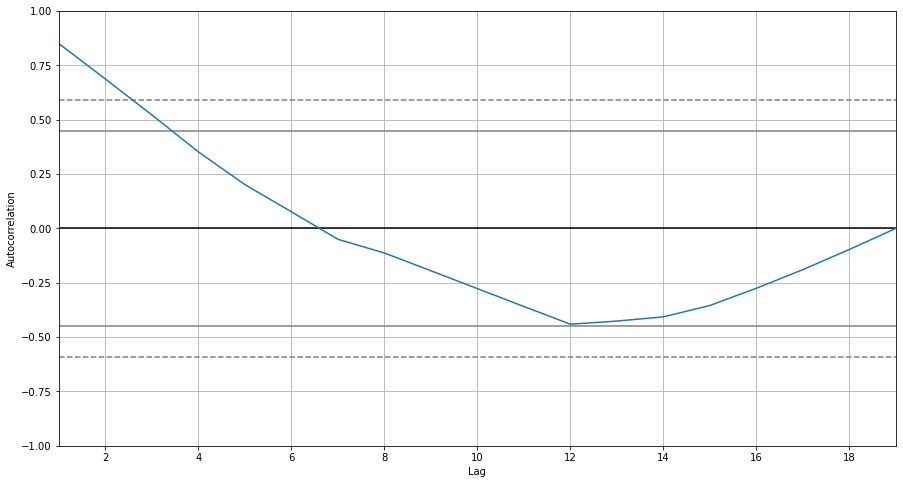

In [18]:
#Autocorrelation plot
autocorrelation_plot(df['Total recovery'])
plt.show();

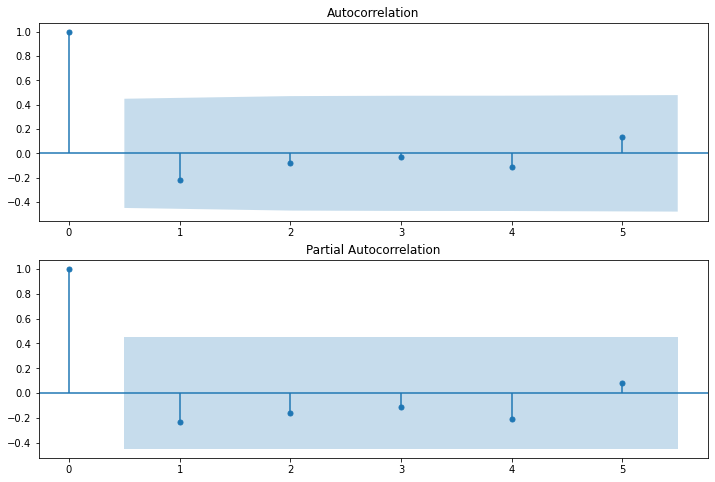

In [26]:
#The ACF plot is to determine the order of the MA
#The PACF is to determine the order of the AR
fig = plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig= sm.graphics.tsa.plot_acf(df['New cases'].dropna(),lags=5,ax=ax1)
ax2= fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(df['New cases'].dropna(),lags=5,ax=ax2)


In [27]:
#In ARIMA, AR has p, I has d, MA has q
#For non-seasonal data
#p=1, d=1, q=0 0r 1
model= ARIMA(df['New cases'], order=(1,1,1))


C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  warnings.warn('No frequency information was'
C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  warnings.warn('No frequency information was'
C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


In [28]:
model_fit= model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.New cases   No. Observations:                   18
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -119.942
Method:                       css-mle   S.D. of innovations            171.923
Date:                Mon, 13 Sep 2021   AIC                            247.885
Time:                        00:38:11   BIC                            251.446
Sample:                             1   HQIC                           248.376
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.5628      5.898      1.282      0.200      -3.997      19.123
ar.L1.D.New cases    -0.2861      0.264     -1.084      0.279      -0.803       0.231
ma.L1.D.New cases    -1.0000      0.156     -6.422      0.000      -1.305      -0.695
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.4959           +0.0000j            3.4959            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [35]:
df['forecast']= model_fit.predict(dynamic=False)

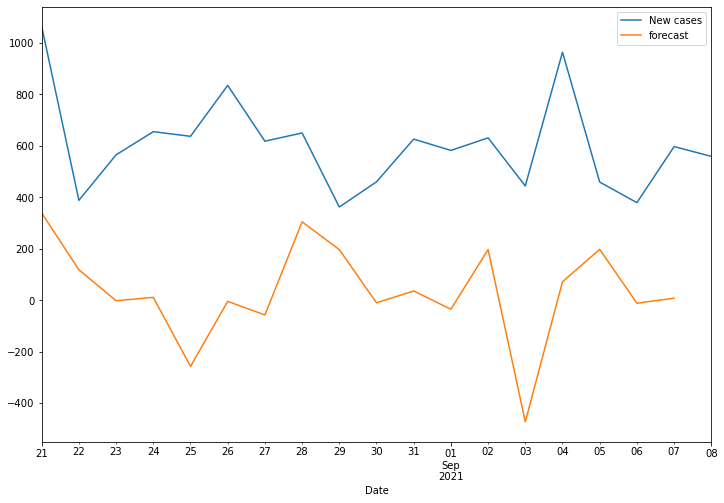

In [36]:
#Plot the results
df[['New cases','forecast']].plot(figsize=(12,8));


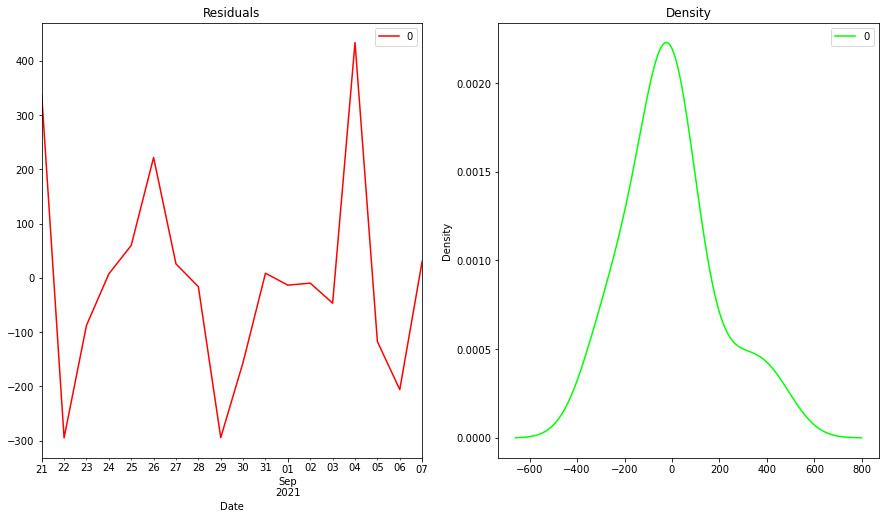

In [45]:
#Plot residuals
residuals = pd.DataFrame(model_fit.resid)
fig,ax =plt.subplots(1,2)
residuals.plot(title ='Residuals',ax=ax[0],color='r')
residuals.plot(kind='kde',title='Density',ax=ax[1],color='lime')
plt.show();

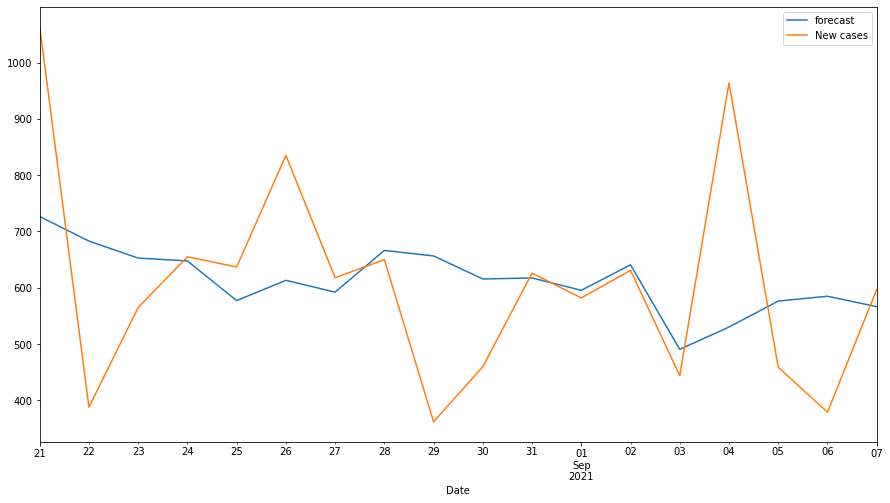

In [46]:
#Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

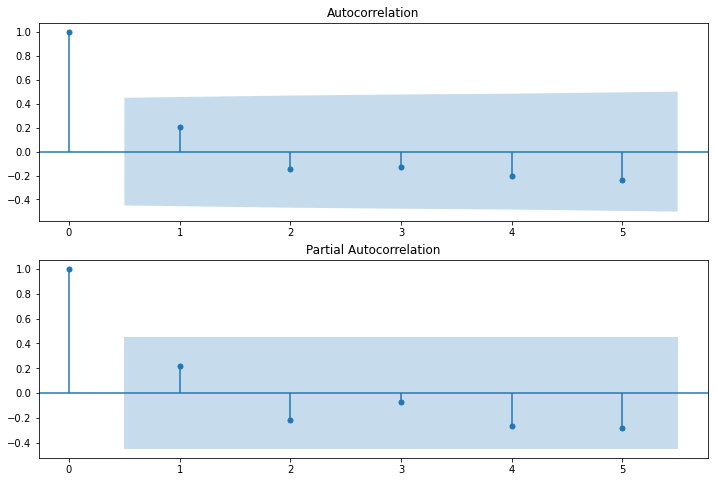

In [47]:
#The ACF plot is to determine the order of the MA
#The PACF is to determine the order of the AR
fig = plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig= sm.graphics.tsa.plot_acf(df['New deaths'].dropna(),lags=5,ax=ax1)
ax2= fig.add_subplot(212)
fig= sm.graphics.tsa.plot_pacf(df['New deaths'].dropna(),lags=5,ax=ax2)


In [48]:
#In ARIMA, AR has p, I has d, MA has q
#For non-seasonal data
#p=1, d=1, q=0 0r 1
model= ARIMA(df['New deaths'], order=(1,1,1))


C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  warnings.warn('No frequency information was'
C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  warnings.warn('No frequency information was'
C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


In [49]:
model_fit= model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.New deaths   No. Observations:                   18
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -81.960
Method:                       css-mle   S.D. of innovations             21.469
Date:                Mon, 13 Sep 2021   AIC                            171.919
Time:                        00:47:53   BIC                            175.481
Sample:                             1   HQIC                           172.410
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0174      1.159     -0.015      0.988      -2.289       2.254
ar.L1.D.New deaths     0.2650      0.237      1.119      0.263      -0.199       0.729
ma.L1.D.New deaths    -1.0000      0.165     -6.079      0.000      -1.322      -0.678
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.7730           +0.0000j            3.7730            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [50]:
df['forecast_new_deaths']= model_fit.predict(dynamic=False)

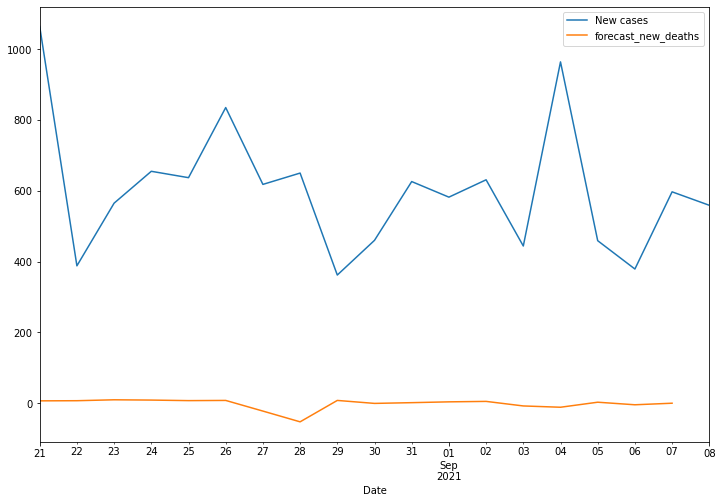

In [51]:
#Plot the results
df[['New cases','forecast_new_deaths']].plot(figsize=(12,8));


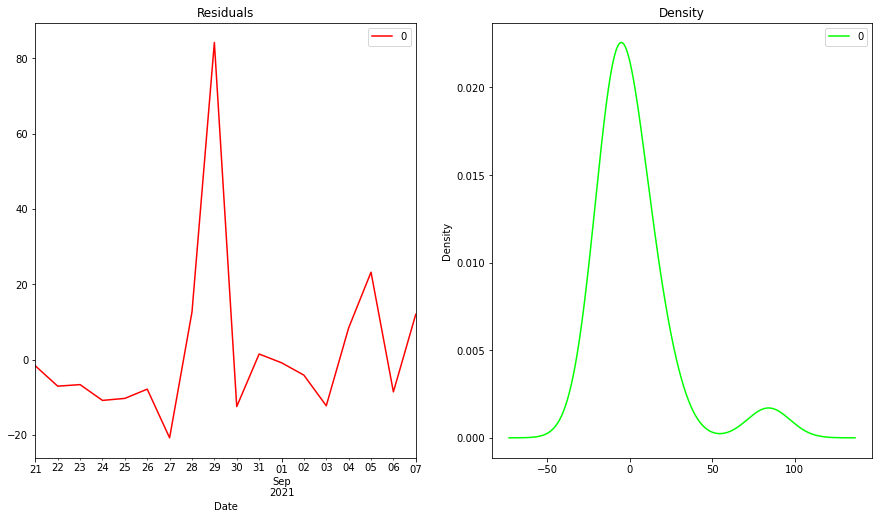

In [52]:
#Plot residuals
residuals = pd.DataFrame(model_fit.resid)
fig,ax =plt.subplots(1,2)
residuals.plot(title ='Residuals',ax=ax[0],color='r')
residuals.plot(kind='kde',title='Density',ax=ax[1],color='lime')
plt.show();

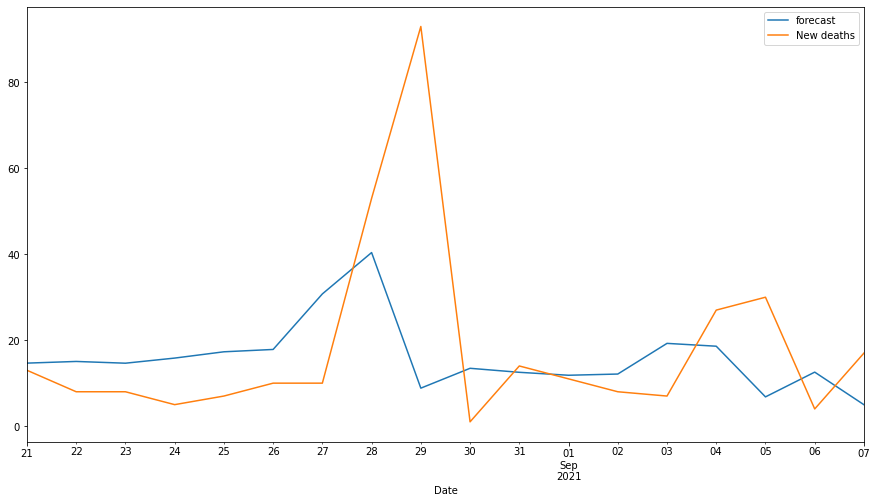

In [53]:
#Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

## Perfomance evaluation for New cases under ARIMA

In [61]:
mse= (mean_squared_error(df['New cases'],df['forecast'].fillna(0)))

In [59]:
rmse = np.sqrt(mean_squared_error(df['New cases'],df['forecast'].fillna(0))).round(2)

In [60]:
mae= mean_absolute_error(df['New cases'].dropna(),df['forecast'].fillna(0))

In [62]:
mape= np.round(np.mean(np.abs(df['New cases']-df['forecast'].fillna(0))/df['New cases'])*100,2)

In [63]:
arima_accuracy_results_new_case=pd.DataFrame({'Method':['ARIMA'],'MSE':[mse],'RMSE':[rmse],'MAE':[mae],'MAPE':[mape]})

In [64]:
arima_accuracy_results_new_case = arima_accuracy_results_new_case[['Method','MSE','RMSE','MAE','MAPE']]
arima_accuracy_results_new_case

,Method,MSE,RMSE,MAE,MAPE
0,ARIMA,373916.261571,611.49,571.143474,95.54


## Perfomance evaluation for New deaths under ARIMA

In [65]:
mse= (mean_squared_error(df['New deaths'],df['forecast_new_deaths'].fillna(0)))

In [66]:
rmse = np.sqrt(mean_squared_error(df['New cases'],df['forecast_new_deaths'].fillna(0))).round(2)

In [67]:
mae= mean_absolute_error(df['New cases'].dropna(),df['forecast_new_deaths'].fillna(0))

In [68]:
mape= np.round(np.mean(np.abs(df['New cases']-df['forecast_new_deaths'].fillna(0))/df['New deaths'])*100,2)

In [69]:
arima_accuracy_results_new_deaths=pd.DataFrame({'Method':['ARIMA'],'MSE':[mse],'RMSE':[rmse],'MAE':[mae],'MAPE':[mape]})

In [70]:
arima_accuracy_results_new_deaths = arima_accuracy_results_new_deaths[['Method','MSE','RMSE','MAE','MAPE']]
arima_accuracy_results_new_deaths

,Method,MSE,RMSE,MAE,MAPE
0,ARIMA,1186.474389,632.72,605.55351,8294.48


## SARIMA

In [83]:
model_sarima_new_cases =SARIMAX(df['New cases'],order=(1,1,1),seasonal_order =(1,1,1,12))
model_sarima_new_cases_fit= model_sarima_new_cases.fit()
model_sarima_new_cases_fit.summary()

C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  warnings.warn('No frequency information was'
C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  warnings.warn('No frequency information was'
C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          New cases   No. Observations:                   19
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -42.634
Date:                            Mon, 13 Sep 2021   AIC                             95.268
Time:                                    01:24:09   BIC                             94.227
Sample:                                         0   HQIC                            91.100
                                             - 19                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1915      5.107      0.038      0.970      -9.817      10.200
ma.L1         -0.9962    102.758     -0.010      0.992    -202.398     200.405
ar.S.L12      -0.9990     10.122     -0.099      0.921     -20.837      18.839
ma.S.L12      -0.9800   9601.668     -0.000      1.000   -1.88e+04    1.88e+04
sigma2        45.0709    265.728      0.170      0.865    -475.746     565.888
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.88   Prob(JB):                         0.91
Heteroskedasticity (H):               8.52   Skew:                            -0.43
Prob(H) (two-sided):                  0.21   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.39e+18. Standard errors may be unstable.
"""

In [84]:
df[['forecast_sarima_new_cases']]= model_sarima_new_cases_fit.predict(dynamics=True)

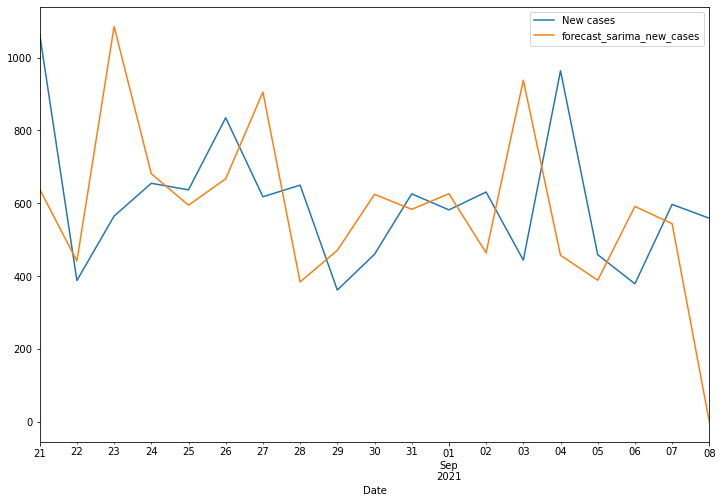

In [85]:
df[['New cases','forecast_sarima_new_cases']].plot(figsize=(12,8));

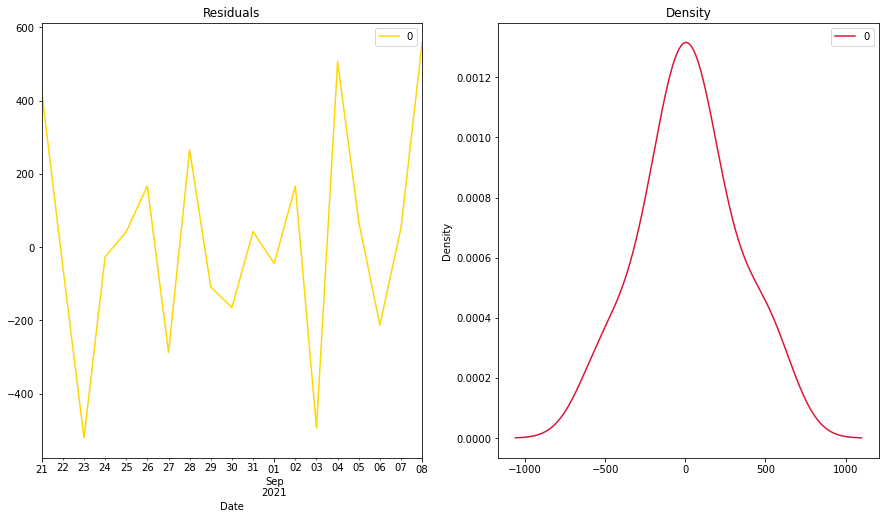

In [88]:
#Plot residual errors
residuals = pd.DataFrame(model_sarima_new_cases_fit.resid)
fig,ax =plt.subplots(1,2)
residuals.plot(title ='Residuals',ax=ax[0],color='gold')
residuals.plot(kind='kde',title='Density',ax=ax[1],color='crimson')
plt.show();

## Performance Evaluation for New cases under SARIMA

In [90]:
mse= (mean_squared_error(df['New cases'],df['forecast_sarima_new_cases'].fillna(0)))

In [91]:
rmse = np.sqrt(mean_squared_error(df['New cases'],df['forecast_sarima_new_cases'].fillna(0))).round(2)

In [92]:
mae= mean_absolute_error(df['New cases'].dropna(),df['forecast_sarima_new_cases'].fillna(0))

In [93]:
mape= np.round(np.mean(np.abs(df['New cases']-df['forecast_sarima_new_cases'].fillna(0))/df['New cases'])*100,2)

In [69]:
sarima_accuracy_results_new_cases=pd.DataFrame({'Method':['ARIMA'],'MSE':[mse],'RMSE':[rmse],'MAE':[mae],'MAPE':[mape]})

In [95]:
sarima_accuracy_results_new_cases = arima_accuracy_results_new_deaths[['Method','MSE','RMSE','MAE','MAPE']]
sarima_accuracy_results_new_cases

,Method,MSE,RMSE,MAE,MAPE
0,ARIMA,1186.474389,632.72,605.55351,8294.48


In [96]:
model_sarima_new_deaths =SARIMAX(df['New deaths'],order=(1,1,1),seasonal_order =(1,1,1,12))
model_sarima_new_deaths_fit= model_sarima_new_cases.fit()
model_sarima_new_deaths_fit.summary()

C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  warnings.warn('No frequency information was'
C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  warnings.warn('No frequency information was'
C:\Users\IBK PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\IBK PC\anaconda3\li

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          New cases   No. Observations:                   19
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -42.634
Date:                            Mon, 13 Sep 2021   AIC                             95.268
Time:                                    05:32:00   BIC                             94.227
Sample:                                         0   HQIC                            91.100
                                             - 19                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1918      5.787      0.033      0.974     -11.150      11.533
ma.L1         -0.9964    109.926     -0.009      0.993    -216.448     214.455
ar.S.L12      -0.9988      9.577     -0.104      0.917     -19.769      17.772
ma.S.L12      -0.9683   7877.527     -0.000      1.000   -1.54e+04    1.54e+04
sigma2        52.3254    168.370      0.311      0.756    -277.674     382.325
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.88   Prob(JB):                         0.91
Heteroskedasticity (H):               8.52   Skew:                            -0.43
Prob(H) (two-sided):                  0.21   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.7e+19. Standard errors may be unstable.
"""

In [97]:
df[['forecast_sarima_new_deaths']]= model_sarima_new_cases_fit.predict(dynamics=True)

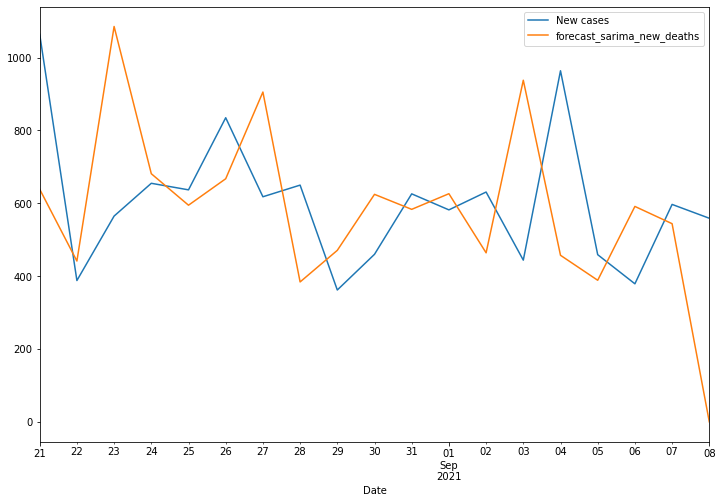

In [98]:
df[['New cases','forecast_sarima_new_deaths']].plot(figsize=(12,8));

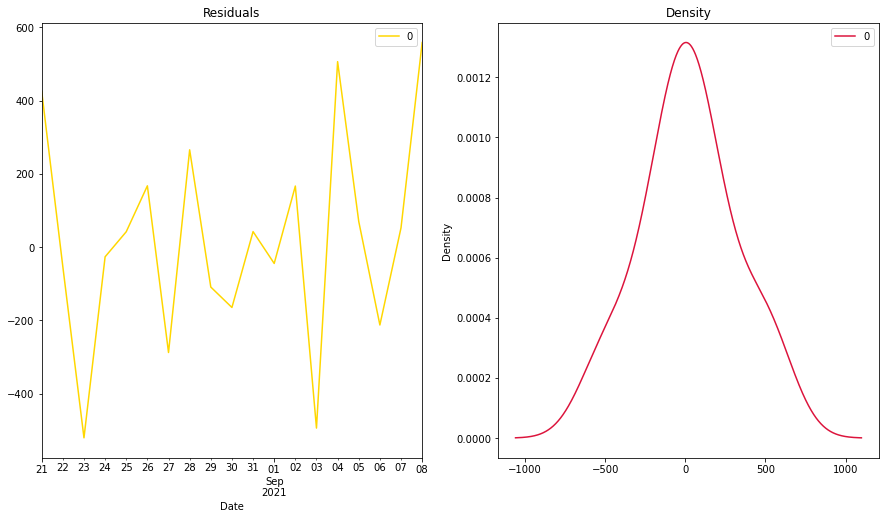

In [99]:
#Plot residual errors
residuals = pd.DataFrame(model_sarima_new_deaths_fit.resid)
fig,ax =plt.subplots(1,2)
residuals.plot(title ='Residuals',ax=ax[0],color='gold')
residuals.plot(kind='kde',title='Density',ax=ax[1],color='crimson')
plt.show();